In [1]:
import pywt
import pandas as pd
import numpy as np
import random
import os
#import lightkurve as lk
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense,Dropout,Activation,Conv1D,SpatialDropout1D,MaxPooling1D,SpatialDropout2D,LeakyReLU,Flatten,BatchNormalization,MaxPooling1D,Input,ReLU,LSTM,GlobalAveragePooling1D
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, normalize 
from tensorflow.keras import callbacks,utils
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy import ndimage
from sklearn import  metrics
from sklearn.metrics import roc_curve,roc_auc_score,auc
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE,ADASYN
from imblearn.under_sampling import RandomUnderSampler,AllKNN,NearMiss,ClusterCentroids
from sklearn.ensemble import RandomForestClassifier
from scipy.signal import savgol_filter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
import time
%matplotlib inline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_classification
from collections import Counter
from keras.optimizers import Adam
from scipy import interpolate
from tensorflow.keras.utils import to_categorical,plot_model
from keras import regularizers  # 过拟合正则化
from keras.regularizers import l2
import tensorflow as tf
import keras.backend as K
#from focal_loss import BinaryFocalLoss,SparseCategoricalFocalLoss

from tensorflow.keras.losses import SparseCategoricalCrossentropy

import scipy.stats as stats
# 解决中文显示问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pc = pd.read_csv('/kaggle/input/exofop-toi-csv/exofop.ipac.caltech.edu_tess_download_toi.txt')   # , sep=',',skiprows=1
print(pc.columns)
pc = pc[~pc.duplicated('TIC ID')] 
print(pc.shape)
pc.head()

Index(['TIC ID', 'TOI', 'Previous CTOI', 'Master', 'SG1A', 'SG1B', 'SG2',
       'SG3', 'SG4', 'SG5', 'ESM', 'TSM', 'Predicted Mass (M_Earth)',
       'Time Series Observations', 'Spectroscopy Observations',
       'Imaging Observations', 'TESS Disposition', 'TFOPWG Disposition',
       'TESS Mag', 'TESS Mag err', 'Planet Name', 'Pipeline Signal ID',
       'Source', 'Detection', 'RA', 'Dec', 'PM RA (mas/yr)',
       'PM RA err (mas/yr)', 'PM Dec (mas/yr)', 'PM Dec err (mas/yr)',
       'Epoch (BJD)', 'Epoch (BJD) err', 'Period (days)', 'Period (days) err',
       'Duration (hours)', 'Duration (hours) err', 'Depth (mmag)',
       'Depth (mmag) err', 'Depth (ppm)', 'Depth (ppm) err',
       'Planet Radius (R_Earth)', 'Planet Radius (R_Earth) err',
       'Planet Insolation (Earth Flux)', 'Planet Equil Temp (K)', 'Planet SNR',
       'Stellar Distance (pc)', 'Stellar Distance (pc) err',
       'Stellar Eff Temp (K)', 'Stellar Eff Temp (K) err',
       'Stellar log(g) (cm/s^2)', 'Stellar 

,TIC ID,TOI,Previous CTOI,Master,SG1A,SG1B,SG2,SG3,SG4,SG5,...,Stellar Radius (R_Sun) err,Stellar Metallicity,Stellar Metallicity err,Stellar Mass (M_Sun),Stellar Mass (M_Sun) err,Sectors,Date TOI Alerted (UTC),Date TOI Updated (UTC),Date Modified,Comments
0,231663901,101.01,NaN,5,5,5,5,5,5,5,...,0.043847,NaN,NaN,1.05,0.129454,"1,27",2018-09-05,2021-10-07,2022-12-14 12:09:24,WASP-46 b
1,149603524,102.01,NaN,5,5,5,5,5,5,5,...,0.050000,0.24,0.05,1.28,0.190812,"1,2,3,4,6,7,8,9,10,11,12,13,27,28,29,30,31,32,...",2019-05-07,2023-04-04,2023-04-07 12:13:06,WASP 62 b
2,336732616,103.01,NaN,5,5,5,5,5,5,5,...,NaN,NaN,NaN,1.27,0.196969,1,2018-09-05,2020-10-27,2022-12-14 12:09:24,HATS-3 b
3,231670397,104.01,NaN,5,5,5,5,5,5,5,...,0.102573,NaN,NaN,1.16,0.166129,"1,27",2018-09-05,2021-12-01,2022-12-14 12:09:24,WASP-73 b
4,144065872,105.01,NaN,5,5,5,5,5,5,5,...,0.059699,NaN,NaN,1.03,0.127209,"1,28",2018-09-05,2021-12-08,2022-12-14 12:09:24,WASP-95; epoch kept from qlp-s28-tois


In [39]:
pc = pc[pc['TFOPWG Disposition'] != 'APC' ]
pc = pc[pc['TFOPWG Disposition'] != 'FA' ]
pc = pc[pc['TFOPWG Disposition'] != 'FP' ]
print(len(pc))
pc['TFOPWG Disposition'].value_counts(), pc['TESS Disposition'].value_counts()

5176


(TFOPWG Disposition
 PC    4384
 KP     504
 CP     286
 Name: count, dtype: int64,
 TESS Disposition
 PC    4526
 KP     484
 CP     166
 Name: count, dtype: int64)

In [42]:
pc1 = pc[['TIC ID','TFOPWG Disposition','TESS Disposition','Period (days)','Duration (hours)',
   'Depth (ppm)','Planet Radius (R_Earth)','Stellar Radius (R_Sun)','Planet SNR']]
pc1

,TIC ID,TFOPWG Disposition,TESS Disposition,Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Stellar Radius (R_Sun),Planet SNR
0,231663901,KP,KP,1.430369,1.643873,19151.216214,13.250493,0.890774,109.606490
1,149603524,KP,KP,4.411938,3.728000,15219.000000,15.569000,1.210000,634.000000
2,336732616,KP,KP,3.547854,3.494333,10424.371800,14.581841,1.400000,59.500000
3,231670397,KP,KP,4.087299,5.586113,3572.171250,13.623773,2.218670,48.678577
4,144065872,KP,KP,2.184667,2.865280,11708.022855,13.702853,1.238240,349.334140
...,...,...,...,...,...,...,...,...,...
6862,261264800,PC,PC,4.767442,1.321031,4898.621861,1.036506,0.125969,7.140531
6863,460950389,PC,PC,2.861878,2.283979,2450.989996,3.903364,0.793587,9.851493
6864,112115898,PC,PC,4.718569,1.145079,1734.867395,1.010243,0.226654,8.033537
6865,34986694,PC,PC,0.470748,0.500961,5060.833528,1.852907,0.219973,7.977471


In [3]:
train = pd.read_csv('/kaggle/input/finllay-fig/X_train_t1.csv',low_memory=False)
train = train[~train.duplicated('TIC')]    # 去重
train

,TIC,toiCount,planet_cnt,xml_sectors_range,estimate_snr_aver,period,type,label,0,1,...,Tmag,sectors,titchN,Disposition,Period,Duration,Transit_Depth,star_rad,SN,subtype
0,350336617,NaN,NaN,NaN,NaN,NaN,V,2.0,0.127210,0.141139,...,NaN,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
1,382552502,NaN,NaN,NaN,NaN,1.0,IS,3.0,0.165196,0.209949,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,231840927,NaN,3.0,35.0,NaN,NaN,EB,0.0,0.714346,0.826396,...,10.0031,"1,2,28,29",4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,410654298,NaN,5.0,64.0,NaN,NaN,EB,0.0,0.962279,0.962440,...,7.8098,"10,11,37",3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,419994778,NaN,3.0,45.0,NaN,NaN,EB,0.0,0.597409,0.642895,...,9.6941,"4,31",2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4314,218354669,1.0,1.0,4.0,0.006716,3.0,PC,1.0,0.342694,0.301967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4315,132313173,1.0,1.0,64.0,0.270769,2.0,PC,1.0,0.690304,0.628754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4316,238164799,1.0,1.0,64.0,0.023952,4.0,PC,1.0,0.413715,0.469190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4317,328325110,1.0,1.0,46.0,7.927671,2.0,PC,1.0,0.703433,0.708856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
result = pd.concat([test,train], axis=0)
result = result.reset_index(drop=True)
result

,TIC,toiCount,planet_cnt,xml_sectors_range,estimate_snr_aver,period,type,label,0,1,...,Tmag,sectors,titchN,Disposition,Period,Duration,Transit_Depth,star_rad,SN,subtype
0,406999263,NaN,NaN,NaN,NaN,NaN,V,2.0,0.877311,0.915042,...,NaN,15,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
1,165642663,NaN,NaN,NaN,NaN,NaN,V,2.0,0.355779,0.308504,...,NaN,26,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ACF
2,319904128,NaN,NaN,NaN,NaN,NaN,V,2.0,0.390205,0.349561,...,NaN,13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ACF
3,160529369,NaN,NaN,NaN,NaN,NaN,V,2.0,0.827191,0.834673,...,NaN,11,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Double-sinusoidal
4,200738653,NaN,NaN,NaN,NaN,NaN,V,2.0,1.000000,0.956621,...,NaN,18,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ACF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,218354669,1.0,1.0,4.0,0.006716,3.0,PC,1.0,0.342694,0.301967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5404,132313173,1.0,1.0,64.0,0.270769,2.0,PC,1.0,0.690304,0.628754,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5405,238164799,1.0,1.0,64.0,0.023952,4.0,PC,1.0,0.413715,0.469190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5406,328325110,1.0,1.0,46.0,7.927671,2.0,PC,1.0,0.703433,0.708856,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train.iloc[:1,-20:]

In [ ]:
snrpc = pd.read_csv('/kaggle/input/tessebs-titch-sectors-right/final2_pc_withsnr.csv',low_memory=False)
snrpc = snrpc[~snrpc.duplicated('TIC')]    # 去重
snrpc = snrpc.reset_index(drop=True)
snrpc.head()

In [ ]:
snrpc['planet_cnt'].value_counts(),snrpc['toiCount'].value_counts(),snrpc['period'].value_counts()

In [ ]:
snrpc1 = snrpc[snrpc['toiCount'] == 4]
snrpc1 = snrpc1[snrpc1['planet_cnt']== 4]
snrpc1['toiCount'].value_counts(), snrpc1['planet_cnt'].value_counts(), snrpc1['type'].value_counts()

In [ ]:
pc2.shape, pc3.shape, pc4.shape, pc5.shape

In [ ]:
snrpc1 = pd.concat([pc2, pc3,pc4, pc5], axis =0)
snrpc1.shape

In [ ]:
snrpc1_t = np.stack((snrpc1.iloc[:,8:508].values, snrpc1.iloc[:,508:1008].values),axis=1)
snrpc1_t = snrpc1_t.reshape((-1, 500, 2)).astype("float32")
snrpc1_t.shape

In [ ]:
y = snrpc1['label'].values
# 将数组元素转换为整数
y = y.astype(int)
# 将标签转换为 One-Hot 编码
snrpc1_y = np.eye(4)[y]
snrpc1_y 

In [115]:
testPC1 = pd.read_csv('/kaggle/working/traintest.csv',low_memory=False)
#test = test[~test.duplicated('TIC')]    # 去重
testPC1.columns

Index(['TIC', 'TFOPWG Disposition', 'TESS Disposition', 'Period (days)',
       'Duration (hours)', 'Depth (ppm)', 'Planet Radius (R_Earth)',
       'Stellar Radius (R_Sun)', 'Planet SNR', 'type', 'subtype', 'label',
       'estimate_snr_aver', 'class_scores_EB', 'class_scores_PC',
       'class_scores_V', 'class_scores_IS', 'predicted_classification'],
      dtype='object')

In [ ]:
/kaggle/input/finllay-fig/Published ConfirmedPS_2023.12.29_04.07.42.csv
/kaggle/input/finllay-fig/mulitiPC.csv

In [106]:
tecs = pd.read_csv('/kaggle/input/finllay-fig/Published ConfirmedPS_2023.12.29_04.07.42.csv',skiprows=103)   # , sep=',',skiprows=1
print(tecs.columns)
#tecs = tecs[~tecs.duplicated('tic_id')]
tecs =tecs[tecs['disc_facility']=='Transiting Exoplanet Survey Satellite (TESS)']
tecs = tecs[tecs['sy_pnum']>1]
tces = tecs[['pl_name', 'disc_facility','discoverymethod','sy_snum','sy_pnum']]
tces = tces[~tces.duplicated('pl_name')]
tces 

Index(['loc_rowid', 'pl_name', 'hostname', 'default_flag', 'sy_snum',
       'sy_pnum', 'discoverymethod', 'disc_year', 'disc_facility', 'soltype',
       'pl_controv_flag', 'pl_refname', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_rade', 'pl_radeerr1',
       'pl_radeerr2', 'pl_radelim', 'pl_radj', 'pl_radjerr1', 'pl_radjerr2',
       'pl_radjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2',
       'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2',
       'pl_bmassjlim', 'pl_bmassprov', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_insollim', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2',
       'pl_eqtlim', 'ttv_flag', 'st_refname', 'st_spectype', 'st_teff',
       'st_tefferr1', 'st_tefferr2', 'st_tefflim', 'st_rad', 'st_raderr1',
       'st_raderr2', 'st_radlim', 'st_mass', 'st_masserr1',

,pl_name,disc_facility,discoverymethod,sy_snum,sy_pnum
0,AU Mic b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3
9,AU Mic c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3
21,GJ 143 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2
24,GJ 3473 b,Transiting Exoplanet Survey Satellite (TESS),Transit,2,2
25,GJ 357 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3
...,...,...,...,...,...
571,WASP-126 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,1,2
572,WASP-132 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2
573,WASP-18 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,2,2
574,WASP-84 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2


In [107]:
pc1 =tces 

In [5]:
test = pd.read_csv('/kaggle/input/finllay-fig/yuliangDS2_PC.csv',low_memory=False)
#test = test[~test.duplicated('TIC')]    # 去重
test1 = pd.read_csv('/kaggle/input/finllay-fig/test1to544.csv',low_memory=False)
test 

,TIC,titchN,0,type,label,1,2,3,4,5,...,490.1,491.1,492.1,493.1,494.1,495.1,496.1,497.1,498.1,499.1
0,231663901,3,0.925788,PC,1,0.741606,0.835103,0.832874,0.822112,0.893029,...,0.060703,0.481662,0.386570,0.426784,0.416623,0.422568,0.420215,0.368978,0.411273,0.450880
1,149603524,4,0.732544,PC,1,0.968938,1.000000,0.989810,0.132312,0.911653,...,0.427145,0.429886,0.391834,0.407004,0.387119,0.438626,0.408297,0.381587,0.406575,0.395467
2,149603524,4,0.732544,PC,1,0.968938,1.000000,0.989810,0.132312,0.911653,...,0.427145,0.429886,0.391834,0.407004,0.387119,0.438626,0.408297,0.381587,0.406575,0.395467
3,149603524,4,0.732544,PC,1,0.968938,1.000000,0.989810,0.132312,0.911653,...,0.427145,0.429886,0.391834,0.407004,0.387119,0.438626,0.408297,0.381587,0.406575,0.395467
4,336732616,1,0.767041,PC,1,0.820106,0.885297,0.900449,0.890792,0.888374,...,0.317413,0.298981,0.299474,0.322081,0.295596,0.264431,0.327285,0.396230,0.394861,0.363352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416,32498861,2,0.852464,PC,1,0.866916,0.858672,0.884047,0.884646,0.856671,...,0.565959,0.636393,0.710710,0.607669,0.623573,0.669358,0.687351,0.649969,0.603616,0.541534
417,435880578,4,0.884772,PC,1,0.771896,0.835523,0.156678,0.656991,0.685327,...,0.402127,0.359942,0.406835,0.409380,0.366223,0.417685,0.408393,0.864283,0.157223,0.481199
418,373491042,1,0.888765,PC,1,0.883003,0.878211,0.874034,0.870851,0.872751,...,0.524536,0.501732,0.482788,0.508405,0.573146,0.577267,0.522884,0.497761,0.510804,0.557002
419,248434780,1,0.632512,PC,1,0.656021,0.689813,0.710808,0.717104,0.743199,...,0.427150,0.298062,0.108757,0.107463,0.323278,0.423955,0.371749,0.319463,0.320623,0.488271


In [110]:
train = train[train['type']=='PC']
test = test1[test1['type']=='PC']

In [13]:
#以某列为索引
train.set_index('TIC', inplace=True)
test.set_index('TIC', inplace=True)

In [92]:
pc.set_index('TIC ID', inplace=True)
pc = pc.loc[:,'Stellar Radius (R_Sun)']
pc

TIC ID
231663901    0.890774
149603524    1.210000
336732616    1.400000
231670397    2.218670
144065872    1.238240
               ...   
261264800    0.125969
460950389    0.793587
112115898    0.226654
34986694     0.219973
405428714    1.680560
Name: Stellar Radius (R_Sun), Length: 5176, dtype: float64

In [15]:
len(test1)

544

In [98]:
result = pd.concat([pc,train], axis=1).reindex(train.index)
result= result.reset_index(drop=False)
result=result.dropna(subset=['Stellar Radius (R_Sun)'])
print(len(result))
result.head()

1299


,TIC,Stellar Radius (R_Sun),toiCount,planet_cnt,xml_sectors_range,estimate_snr_aver,period,type,label,0,...,Tmag,sectors,titchN,Disposition,Period,Duration,Transit_Depth,star_rad,SN,subtype
0,235905185,1.020000,1.0,1.0,46.0,0.053175,4.0,PC,1.0,0.636455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,372759746,1.160000,1.0,1.0,36.0,0.585580,4.0,PC,1.0,0.189967,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,103633672,0.799051,1.0,1.0,46.0,2.801194,4.0,PC,1.0,0.568881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14344979,0.916164,1.0,1.0,45.0,0.432026,3.0,PC,1.0,0.733404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,219852584,1.597150,1.0,1.0,46.0,0.024634,4.0,PC,1.0,0.868164,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
# 使用Seaborn绘制SNR分布的直方图
fig = plt.figure(figsize=(8,6)) 
sns.histplot(result['estimate_snr_aver'], kde=True, bins=50)  # kde=True绘制核密度估计
plt.xlabel('Estimated SNR (PC)',fontsize=15)
plt.ylabel('Count',fontsize=15)
#plt.title('SNR Distribution')
plt.xticks(fontsize=15,fontname='Times New Roman')
plt.yticks(fontsize=15,fontname='Times New Roman')
plt.show()
fig.savefig("train_pc_est_snr.png", dpi=400)

KeyError: 'Depth (ppm)'

<Figure size 800x600 with 0 Axes>

In [120]:
result = train

In [121]:
# 假设 pc['estimate_snr_aver'] 是你的数据
data = result['estimate_snr_aver']
# 使用 numpy.histogram 计算直方图的频率和边缘
hist, edges = np.histogram(data, bins=50)

# 打印每个 bin 的数据
for i in range(len(hist)):
    print(f"Bin {i + 1}: {edges[i]} - {edges[i + 1]} | Frequency: {hist[i]}")

Bin 1: 1.3421411463954474e-05 - 0.7309853029832347 | Frequency: 1063
Bin 2: 0.7309853029832347 - 1.4619571845550055 | Frequency: 124
Bin 3: 1.4619571845550055 - 2.1929290661267764 | Frequency: 66
Bin 4: 2.1929290661267764 - 2.923900947698547 | Frequency: 44
Bin 5: 2.923900947698547 - 3.6548728292703174 | Frequency: 24
Bin 6: 3.6548728292703174 - 4.385844710842089 | Frequency: 6
Bin 7: 4.385844710842089 - 5.116816592413859 | Frequency: 8
Bin 8: 5.116816592413859 - 5.84778847398563 | Frequency: 3
Bin 9: 5.84778847398563 - 6.5787603555574 | Frequency: 4
Bin 10: 6.5787603555574 - 7.309732237129171 | Frequency: 6
Bin 11: 7.309732237129171 - 8.04070411870094 | Frequency: 8
Bin 12: 8.04070411870094 - 8.771676000272713 | Frequency: 5
Bin 13: 8.771676000272713 - 9.502647881844483 | Frequency: 0
Bin 14: 9.502647881844483 - 10.233619763416254 | Frequency: 2
Bin 15: 10.233619763416254 - 10.964591644988024 | Frequency: 1
Bin 16: 10.964591644988024 - 11.695563526559795 | Frequency: 0
Bin 17: 11.6955

In [122]:
# 假设 pc['estimate_snr_aver'] 是你的数据
data = result['estimate_snr_aver']

# 使用 numpy.histogram 计算直方图的频率和边缘
hist, edges = np.histogram(data, bins=50)

# 使用 numpy.digitize 找到每个数据点所在的 bin 编号
bin_indices = np.digitize(data, edges)

# 通过 bin 编号提取相应的数据
bin40 = []
minn= []
for i in range(1, len(edges)):
    bin_data = data[bin_indices == i]
    bin40.append(bin_data)
    #print(i, len(bin_data))
    #print(f"Bin {i}: {edges[i - 1]} - {edges[i]} | Data: {bin_data}")
    minnn = (edges[i - 1] + edges[i]) / 2
    #print((edges[i - 1] + edges[i]) / 2)
    minn.append(minnn)
len(minn)

50

In [27]:
selected_data.iloc[:,500:]

,0.1,1.1,2.1,3.1,4.1,5.1,6.1,7.1,8.1,9.1,...,490.1,491.1,492.1,493.1,494.1,495.1,496.1,497.1,498.1,499.1


In [55]:
test.iloc[:,5:1005]

,0,1,2,3,4,5,6,7,8,9,...,490.1,491.1,492.1,493.1,494.1,495.1,496.1,497.1,498.1,499.1
0,0.189967,0.181216,0.204362,0.224407,0.233999,0.252925,0.249949,0.241388,0.289908,0.310134,...,0.653253,0.650159,0.619628,0.646737,0.626593,0.663195,0.736479,0.434498,0.609419,0.629173
1,0.481116,0.579729,0.582660,0.603267,0.542812,0.568050,0.563184,0.517217,0.535972,0.578924,...,0.542241,0.542745,0.531303,0.556526,0.500383,0.574546,0.575861,0.538680,0.533379,0.597838
2,0.622231,0.385835,0.153770,0.759448,0.619942,0.588948,0.702532,0.508541,0.676047,0.675554,...,0.442063,0.329527,0.423942,0.309477,0.397686,0.427230,0.353662,0.236476,0.454774,0.362694
3,1.000000,0.543406,0.855011,0.732555,0.791711,0.758855,0.510437,0.723888,0.774604,0.879050,...,0.304957,0.375431,0.423057,0.489371,0.458001,0.458442,0.446655,0.531208,0.506812,0.105957
4,0.712103,0.867849,0.755314,0.228907,0.543533,0.620206,0.666637,0.680426,0.616722,0.679021,...,0.705344,0.531452,0.606169,0.416606,0.712725,0.715079,0.544816,0.412665,0.140606,0.721062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.763723,0.895366,0.946758,0.942462,0.949185,0.949821,0.934785,0.918516,0.933055,0.883134,...,0.500239,0.397625,0.529958,0.284058,0.468064,0.568903,0.447541,0.517106,1.000000,0.559381
163,0.835171,0.894553,0.915531,0.945240,0.943741,0.920306,0.934470,0.959392,0.930592,0.941039,...,0.521926,0.534070,0.542123,0.541451,0.543284,0.522227,0.538787,0.496864,0.551858,0.614637
164,0.862489,0.863677,0.831425,0.744055,0.052883,0.891044,0.793104,0.864866,0.835793,0.800164,...,0.395678,0.485220,0.125061,0.260377,0.518219,0.392965,0.407949,0.395117,0.415312,0.402769
165,1.000000,0.535636,0.676392,0.682231,0.695831,0.703317,0.698935,0.694947,0.698230,0.695463,...,0.407812,0.375531,0.409145,0.406163,0.409624,0.373648,0.372298,0.362457,0.416767,0.438753


In [52]:
test.iloc[:,7]

0      0.204362
1      0.582660
2      0.153770
3      0.855011
4      0.755314
         ...   
162    0.946758
163    0.915531
164    0.831425
165    0.676392
166    0.412093
Name: 2, Length: 167, dtype: float64

In [ ]:
test

In [57]:
selected_data = test.iloc[:,5:1005]
selected_data_X = np.stack((selected_data.iloc[:,:500].values, selected_data.iloc[:,500:].values),axis=1)
selected_data_X = selected_data_X.reshape((-1, 500, 2)).astype("float32") 
    
y = test.iloc[:,4].values
    # 将数组元素转换为整数
y = y.astype(int)
# 将标签转换为 One-Hot 编码
y_test  = np.eye(4)[y]
    
y_predict = np.argmax(model.predict(selected_data_X), axis=1)  # 得出 0 1 2 3 
len(y_predict)

6/6 [==============================] - 0s 34ms/step


167

In [64]:
y_predict

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 3, 0, 0, 0, 0, 0])

In [60]:
class_scores = model.predict(selected_data_X)
class_scores 

6/6 [==============================] - 0s 5ms/step


array([[4.79257286e-01, 5.17455637e-01, 1.12628611e-03, 2.16080644e-03],
       [8.32584381e-01, 1.67362243e-01, 6.20395184e-08, 5.33459970e-05],
       [1.00400031e-01, 8.99599493e-01, 4.99205299e-09, 3.75348350e-07],
       [2.13670805e-01, 7.86326170e-01, 1.95176014e-07, 2.81924986e-06],
       [2.32929215e-01, 7.67068207e-01, 3.65810919e-08, 2.51605002e-06],
       [2.32929215e-01, 7.67068207e-01, 3.65810919e-08, 2.51605002e-06],
       [2.32929215e-01, 7.67068207e-01, 3.65810919e-08, 2.51605002e-06],
       [2.32929215e-01, 7.67068207e-01, 3.65810919e-08, 2.51605002e-06],
       [8.82012546e-01, 1.17909528e-01, 6.13596130e-05, 1.65881775e-05],
       [8.82012546e-01, 1.17909528e-01, 6.13596130e-05, 1.65881775e-05],
       [6.00949451e-02, 9.39902365e-01, 8.37177794e-08, 2.61492596e-06],
       [1.01453669e-01, 8.98538768e-01, 5.11189562e-08, 7.50862728e-06],
       [1.01453669e-01, 8.98538768e-01, 5.11189562e-08, 7.50862728e-06],
       [1.10121578e-01, 8.89876842e-01, 3.66258135e

In [61]:
sc = pd.DataFrame(class_scores)
column_mapping = {
    0: 'class_scores_EB',
    1: 'class_scores_PC',
    2: 'class_scores_V',
    3: 'class_scores_IS',
    # ...
}

# 使用 rename 方法修改列名
sc.rename(columns=column_mapping, inplace=True)
sc

,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS
0,0.479257,0.517456,1.126286e-03,2.160806e-03
1,0.832584,0.167362,6.203952e-08,5.334600e-05
2,0.100400,0.899599,4.992053e-09,3.753483e-07
3,0.213671,0.786326,1.951760e-07,2.819250e-06
4,0.232929,0.767068,3.658109e-08,2.516050e-06
...,...,...,...,...
162,0.523199,0.476796,3.136289e-07,4.584091e-06
163,0.677425,0.322560,4.836026e-08,1.445141e-05
164,0.939987,0.059946,2.652514e-05,3.993761e-05
165,0.959469,0.040512,5.866323e-07,1.879895e-05


In [62]:
predicted  = {'predicted_classification':y_predict} # 'period': titchN
pr = pd.DataFrame(predicted)
pr

,predicted_classification
0,1
1,0
2,1
3,1
4,1
...,...
162,0
163,0
164,0
165,0


In [63]:
pr.loc[pr['predicted_classification'] == 0, 'predicted_classification'] = "EB"
pr.loc[pr['predicted_classification'] == 1, 'predicted_classification'] = "PC"
pr.loc[pr['predicted_classification'] == 2, 'predicted_classification'] = "V"
pr.loc[pr['predicted_classification'] == 3, 'predicted_classification'] = "IS"

In [65]:
pr

,predicted_classification
0,PC
1,EB
2,PC
3,PC
4,PC
...,...
162,EB
163,EB
164,EB
165,EB


In [95]:
df = pd.concat([test,sc,pr], axis=1)
df = df.reset_index(drop=True)
df

,TIC,titchN,type,SUBtype,label,0,1,2,3,4,...,495.1,496.1,497.1,498.1,499.1,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,2,PC,multi,1,0.189967,0.181216,0.204362,0.224407,0.233999,...,0.663195,0.736479,0.434498,0.609419,0.629173,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,4,PC,multi,1,0.481116,0.579729,0.582660,0.603267,0.542812,...,0.574546,0.575861,0.538680,0.533379,0.597838,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,3,PC,multi,1,0.622231,0.385835,0.153770,0.759448,0.619942,...,0.427230,0.353662,0.236476,0.454774,0.362694,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,3,PC,multi,1,1.000000,0.543406,0.855011,0.732555,0.791711,...,0.458442,0.446655,0.531208,0.506812,0.105957,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,3,PC,multi,1,0.712103,0.867849,0.755314,0.228907,0.543533,...,0.715079,0.544816,0.412665,0.140606,0.721062,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,4,PC,multi,1,0.763723,0.895366,0.946758,0.942462,0.949185,...,0.568903,0.447541,0.517106,1.000000,0.559381,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,3,PC,multi,1,0.835171,0.894553,0.915531,0.945240,0.943741,...,0.522227,0.538787,0.496864,0.551858,0.614637,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,4,PC,multi,1,0.862489,0.863677,0.831425,0.744055,0.052883,...,0.392965,0.407949,0.395117,0.415312,0.402769,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,2,PC,multi,1,1.000000,0.535636,0.676392,0.682231,0.695831,...,0.373648,0.372298,0.362457,0.416767,0.438753,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


In [96]:
df1 = df[['TIC','type','SUBtype','label','class_scores_EB',
   'class_scores_PC','class_scores_V','class_scores_IS','predicted_classification']]
df1

,TIC,type,SUBtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,PC,multi,1,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,PC,multi,1,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,PC,multi,1,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,PC,multi,1,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,PC,multi,1,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,PC,multi,1,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,PC,multi,1,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,PC,multi,1,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,PC,multi,1,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


In [99]:
df1

,TIC,type,SUBtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,PC,multi,1,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,PC,multi,1,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,PC,multi,1,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,PC,multi,1,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,PC,multi,1,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,PC,multi,1,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,PC,multi,1,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,PC,multi,1,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,PC,multi,1,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


In [100]:
df1.columns = ['TIC', 'type', 'subtype', 'label', 'class_scores_EB', 'class_scores_PC',
       'class_scores_V', 'class_scores_IS', 'predicted_classification',]

In [101]:
df1['subtype'] ='multiple'
df1

/tmp/ipykernel_32/1145575830.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['subtype'] ='multiple'


,TIC,type,subtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,PC,multiple,1,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,PC,multiple,1,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,PC,multiple,1,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,PC,multiple,1,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,PC,multiple,1,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,PC,multiple,1,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,PC,multiple,1,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,PC,multiple,1,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,PC,multiple,1,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


,TIC,type,subtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification,subtype


In [108]:
#以某列为索引
pc1.set_index('pl_name', inplace=True)
df1.set_index('TIC', inplace=True)

In [109]:
df2 = pd.concat([pc1,df1], axis=1).reindex(df1.index)
df2 = df2.reset_index(drop=False)
df2

,TIC,disc_facility,discoverymethod,sy_snum,sy_pnum,type,subtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3,PC,multiple,1.0,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3,PC,multiple,1.0,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,5,PC,multiple,1.0,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,1,2,PC,multiple,1.0,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,2,2,PC,multiple,1.0,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


In [112]:
df2

,TIC,disc_facility,discoverymethod,number_of_stars,number_of_planets,type,subtype,label,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,AU Mic b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3,PC,multiple,1.0,0.479257,0.517456,1.126286e-03,2.160806e-03,PC
1,GJ 143 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.832584,0.167362,6.203952e-08,5.334600e-05,EB
2,GJ 357 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,3,PC,multiple,1.0,0.100400,0.899599,4.992053e-09,3.753483e-07,PC
3,GJ 806 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.213671,0.786326,1.951760e-07,2.819250e-06,PC
4,HD 108236 b,Transiting Exoplanet Survey Satellite (TESS),Transit,1,5,PC,multiple,1.0,0.232929,0.767068,3.658109e-08,2.516050e-06,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,WASP-126 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,1,2,PC,multiple,1.0,0.523199,0.476796,3.136289e-07,4.584091e-06,EB
163,WASP-132 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.677425,0.322560,4.836026e-08,1.445141e-05,EB
164,WASP-18 c,Transiting Exoplanet Survey Satellite (TESS),Transit Timing Variations,2,2,PC,multiple,1.0,0.939987,0.059946,2.652514e-05,3.993761e-05,EB
165,WASP-84 c,Transiting Exoplanet Survey Satellite (TESS),Transit,1,2,PC,multiple,1.0,0.959469,0.040512,5.866323e-07,1.879895e-05,EB


In [111]:
df2.columns = ['TIC', 'disc_facility', 'discoverymethod', 'number_of_stars', 'number_of_planets', 'type',
       'subtype', 'label', 'class_scores_EB', 'class_scores_PC',
       'class_scores_V', 'class_scores_IS', 'predicted_classification']

In [47]:
# 定义排序顺序
custom_order = ['PC', 'EB', 'V', 'IS']

# 将 'your_column' 列转换为 Categorical 类型，并指定排序顺序
df2['type'] = pd.Categorical(df2['type'], categories=custom_order, ordered=True)

# 使用 sort_values 方法按照 'your_column' 列排序
df_sorted = df2.sort_values(by='type')

# 打印排序后的 DataFrame
df_sorted

,TIC,TFOPWG Disposition,TESS Disposition,Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Stellar Radius (R_Sun),Planet SNR,type,subtype,label,estimate_snr_aver,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
5407,33831980,PC,PC,21.916540,3.504906,1246.113958,2.282026,0.631609,13.879484,PC,NaN,1.0,0.033256,1.303647e-02,0.986962,3.579658e-08,0.000001,PC
4706,458686847,KP,PC,1.291597,1.154881,1466.319907,2.100622,0.514745,8.947783,PC,NaN,1.0,0.001956,1.065680e-02,0.989337,7.159549e-08,0.000007,PC
4707,420680343,PC,PC,3.763031,3.503000,1580.000000,5.967050,1.500000,17.000000,PC,NaN,1.0,0.027123,5.769803e-02,0.942294,3.130077e-07,0.000007,PC
4708,35516889,KP,KP,0.788839,1.596711,22431.915163,16.124713,1.028050,211.581670,PC,NaN,1.0,0.023803,2.079281e-01,0.792046,5.789680e-06,0.000020,PC
4709,85429139,PC,PC,4.742713,3.115000,13560.000000,17.876000,1.510000,156.000000,PC,NaN,1.0,1.437281,2.923968e-01,0.707597,3.690658e-08,0.000006,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174,231867117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,3.846569e-05,0.006835,1.260600e-01,0.867066,IS
2531,80082449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,1.819008e-04,0.025220,4.368965e-04,0.974161,IS
2528,397136048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,2.574890e-07,0.000292,1.555244e-04,0.999552,IS
3053,389865251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,1.535981e-04,0.004494,4.922072e-01,0.503145,IS


In [48]:
df_sorted = df_sorted.reset_index(drop=True)
df_sorted

,TIC,TFOPWG Disposition,TESS Disposition,Period (days),Duration (hours),Depth (ppm),Planet Radius (R_Earth),Stellar Radius (R_Sun),Planet SNR,type,subtype,label,estimate_snr_aver,class_scores_EB,class_scores_PC,class_scores_V,class_scores_IS,predicted_classification
0,33831980,PC,PC,21.916540,3.504906,1246.113958,2.282026,0.631609,13.879484,PC,NaN,1.0,0.033256,1.303647e-02,0.986962,3.579658e-08,0.000001,PC
1,458686847,KP,PC,1.291597,1.154881,1466.319907,2.100622,0.514745,8.947783,PC,NaN,1.0,0.001956,1.065680e-02,0.989337,7.159549e-08,0.000007,PC
2,420680343,PC,PC,3.763031,3.503000,1580.000000,5.967050,1.500000,17.000000,PC,NaN,1.0,0.027123,5.769803e-02,0.942294,3.130077e-07,0.000007,PC
3,35516889,KP,KP,0.788839,1.596711,22431.915163,16.124713,1.028050,211.581670,PC,NaN,1.0,0.023803,2.079281e-01,0.792046,5.789680e-06,0.000020,PC
4,85429139,PC,PC,4.742713,3.115000,13560.000000,17.876000,1.510000,156.000000,PC,NaN,1.0,1.437281,2.923968e-01,0.707597,3.690658e-08,0.000006,PC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5403,231867117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,3.846569e-05,0.006835,1.260600e-01,0.867066,IS
5404,80082449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,1.819008e-04,0.025220,4.368965e-04,0.974161,IS
5405,397136048,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,2.574890e-07,0.000292,1.555244e-04,0.999552,IS
5406,389865251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,IS,NaN,3.0,NaN,1.535981e-04,0.004494,4.922072e-01,0.503145,IS


In [113]:
df2.to_csv('multi.csv',index = False)

In [124]:
recalpc = []
for i in range(len(bin40)):
    selected_data = result.loc[bin40[i].index].iloc[:,8:1008]
    selected_data_X = np.stack((selected_data.iloc[:,:500].values, selected_data.iloc[:,500:].values),axis=1)
    selected_data_X = selected_data_X.reshape((-1, 500, 2)).astype("float32") 
    
    y = result.loc[bin40[i].index].iloc[:,8].values
    # 将数组元素转换为整数
    y = y.astype(int)
    # 将标签转换为 One-Hot 编码
    y_test  = np.eye(4)[y]
    
    if(len(y_test)!=0):
        y_predict = np.argmax(model.predict(selected_data_X), axis=1)  # 得出 0 1 2 3 
        #print(len(y_predict), Counter(y_predict)[1])
        print( Counter(y_predict)[1] / len(y_predict))
        recal = Counter(y_predict)[1] / len(y_predict)
        recalpc.append(recal)
    else:
        recalpc.append(-1)

34/34 [==============================] - 0s 5ms/step
0.9708372530573848
4/4 [==============================] - 0s 5ms/step
0.9112903225806451
3/3 [==============================] - 0s 5ms/step
0.9393939393939394
2/2 [==============================] - 0s 5ms/step
0.9090909090909091
1/1 [==============================] - 0s 19ms/step
0.9583333333333334
1/1 [==============================] - 0s 21ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 18ms/step
0.6666666666666666
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 18ms/step
0.8333333333333334
1/1 [==============================] - 0s 19ms/step
0.875
1/1 [==============================] - 0s 18ms/step
0.8
1/1 [==============================] - 0s 18ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0
1/1 [==============================] - 0s 20ms/step
1.0
1/1 [==============================] - 0s 19ms/step
1.0

In [125]:
#train
xy = []
for i in range(len(recalpc)):
    if recalpc[i] != -1 and recalpc[i]!=0:
        xy.append((minn[i],recalpc[i]))  

In [118]:
#test
xy1 = []
for i in range(len(recalpc)):
    if recalpc[i] != -1 and recalpc[i]!=0:
        xy1.append((minn[i],recalpc[i]))  
# 提取数据
x_values1 = [item[0] for item in xy1]
y_values1 = [item[1] for item in xy1]

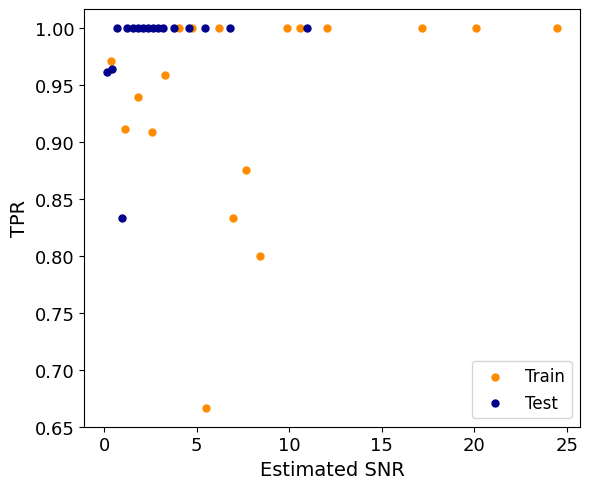

In [127]:
# 提取数据
x_values = [item[0] for item in xy]
y_values = [item[1] for item in xy]

# 绘制散点图
fig = plt.figure(figsize=(6,5))
plt.scatter(x_values, y_values, label='Train',s=25,color='darkorange')
plt.scatter(x_values1, y_values1, label='Test',s=25,color='darkblue')

plt.style.use('default') #('seaborn')
# 手动更改背景颜色
fig.patch.set_facecolor('white')
plt.grid(False)

# 添加标题和标签
plt.xlabel('Estimated SNR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
#plt.title('SNR Distribution')
plt.xticks(fontsize=13,fontname='Times New Roman')
plt.yticks(fontsize=13,fontname='Times New Roman')
plt.tight_layout() 
# 显示图例
plt.legend(fontsize='large',loc='lower right')
fig.savefig("Estimated pc.png", dpi=400)

In [106]:
# 使用Seaborn绘制SNR分布的直方图
fig = plt.figure(figsize=(8,6)) 
sns.histplot(pc['estimate_snr_aver'], kde=True, bins=100)  # kde=True绘制核密度估计

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlabel('Estimated SNR (PC)',fontsize=15)
plt.ylabel('Count',fontsize=15)
#plt.title('SNR Distribution')
plt.xticks(fontsize=15,fontname='Times New Roman')
plt.yticks(fontsize=15,fontname='Times New Roman')
plt.show()
fig.savefig("train_pc_est_snr.png", dpi=400)

KeyError: 'estimate_snr_aver'

<Figure size 800x600 with 0 Axes>

In [ ]:
pc = pc.sort_values(by='estimate_snr_aver', ascending=True)
pc

In [ ]:
len(snr_groups),len(snr_groups[0]),  snr_groups[0].index

In [ ]:
# 定义每组的数量
group_size = 20

# 将数据分成若干组
snr_groups = [pc[i:i+group_size] for i in range(0, len(pc), group_size)]

# 计算每组的平均值 作为x值
average_snr_per_group = [np.mean(group) for group in snr_groups]

In [ ]:
average_snr_per_group

In [ ]:
recalpc = []
for i in range(len(snr_groups)):
    selected_data = test.loc[snr_groups[i].index].iloc[:,8:-15]
    selected_data_X = np.stack((selected_data.iloc[:,:500].values, selected_data.iloc[:,500:].values),axis=1)
    selected_data_X = selected_data_X.reshape((-1, 500, 2)).astype("float32") 
    
    y = test.loc[snr_groups[i].index].iloc[:,7].values
    # 将数组元素转换为整数
    y = y.astype(int)
    # 将标签转换为 One-Hot 编码
    y_test  = np.eye(4)[y]
    

    y_predict = np.argmax(model.predict(selected_data_X), axis=1)  # 得出 0 1 2 3 
    print(len(y_predict), Counter(y_predict)[1])
    print( Counter(y_predict)[1] / len(y_predict))
    recal = Counter(y_predict)[1] / len(y_predict)
    recalpc.append(recal)

In [ ]:
xy = []
for i in range(len(recalpc)):
    if recalpc[i] != -1 and recalpc[i]!=0:
        xy.append((minn[i],recalpc[i]))  

In [ ]:
xy

In [7]:
X_train = train.iloc[:,8:-15]
X_test = test1.iloc[:,8:-15]
#X_val = X_val_t.iloc[:,8:-15]
X_train.shape,X_test.shape

((4319, 1000), (544, 1000))

In [8]:
y_train = to_categorical(train['label'])
#y_test = to_categorical(test['label'])
#y_val = to_categorical(y_val)
y_train

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [9]:
y = test1['label'].values
# 将数组元素转换为整数
y = y.astype(int)
# 将标签转换为 One-Hot 编码
y_test  = np.eye(4)[y]
print(len(y_test ))
y_test 

544


array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [10]:
''' 双通道拼接，{ca,cd}'''

X_train = np.stack((X_train.iloc[:,:500].values, X_train.iloc[:,500:].values),axis=1)
X_test = np.stack((X_test.iloc[:,:500].values, X_test.iloc[:,500:].values),axis=1)
#X_val = np.stack((X_val.iloc[:,:500].values, X_val.iloc[:,500:].values),axis=1)
X_train.shape, X_test.shape#, X_val.shape

((4319, 2, 500), (544, 2, 500))

In [11]:
# astype("float32")
X_train = X_train.reshape((-1, 500, 2)).astype("float32")   # X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape((-1, 500, 2)).astype("float32")
#X_val = X_val.reshape((-1, 500, 2)).astype("float32")
X_train.shape, X_test.shape, y_train.shape, y_test.shape,

((4319, 500, 2), (544, 500, 2), (4319, 4), (544, 4))

In [ ]:
X_test.shape, snrpc1_t.shape

In [ ]:
X_test = np.concatenate((X_test, snrpc1_t), axis=0)
X_test.shape, snrpc1_t.shape

In [ ]:
y_test.shape,  snrpc1_y.shape

In [ ]:
y_test = np.concatenate((y_test, snrpc1_y), axis=0)
y_test.shape, snrpc1_y.shape

In [ ]:
snrpc1_y

In [9]:
from keras.layers import Concatenate,GlobalMaxPooling1D,multiply,Reshape,Lambda,Multiply
from keras.layers import LeakyReLU,SeparableConv1D,add

In [10]:
# verbose：日志显示函数，verbose = 0 为不在标准输出流输出日志信息，verbose = 1 为输出进度条记录，verbose = 2 为每一个epoch输出一行记录
callbacks_list = [
    # mode:loss小好，acc大好，patience:n周期无提升则退出，restore_best_weights:取最优权重
    # EarlyStopping(monitor='val_accuracy', min_delta=0, patience=80, mode='max', verbose=1,
    # 如果restore_best_weights默认为False，False保留最后一次训练时的权重参数，True保存训练过程中准确率最高或者误差最时的网络权重。
    #callbacks.EarlyStopping(monitor="val_loss", patience=30, mode="min",restore_best_weights = True),
    callbacks.EarlyStopping(monitor="val_accuracy", patience=50, mode="max",restore_best_weights = True),
    
    # 保存模型
    #callbacks.ModelCheckpoint(filepath = 'my_model9.h5', monitor='val_accuracy', save_best_only=True, mode='max'),  
    # 本代码矩阵中是val_accuracy不是val_acc
    
    #TensorBoard(log_dir='log4'),
    # 下降学习率
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=1, patience=12) ,
    #LearningRateLogger()
    ]

In [40]:
def inception_module2(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv1D(f1, 1, padding='same', activation='relu')(layer_in)
    
    # 3x3 conv
    conv3 = Conv1D(f2_in, 1, padding='same', activation='relu')(layer_in)
    conv3 = Conv1D(f2_out, 3, padding='same', activation='relu')(conv3)
    
    # 5x5 conv
    conv5 = Conv1D(f3_in, 1, padding='same', activation='relu')(layer_in)
    conv5 = Conv1D(f3_out, 5, padding='same', activation='relu')(conv5)
    
    # 3x3 max pooling
    pool = MaxPooling1D(1, strides=None, padding='same')(layer_in)  
    pool = Conv1D(f4_out, 1, padding='same', activation='relu')(pool)
    
    layer_out = Concatenate(axis=-1)([conv1, conv3, conv5, pool])  # concatenate filters, assumes filters/channels last
    
    return layer_out

In [18]:
import  keras

In [19]:
import  keras
model = keras.models.load_model('/kaggle/input/finllay-fig/4classify_model_94.hdf5')

In [14]:
score = model.evaluate(X_test, y_test, verbose=2)
#score = model.evaluate(snrpc1_t, snrpc1_y , verbose=2)
print('Accuracy: {0:.4%}'.format(score[1]/1))
print("Loss: %.4f\n" % score[0])

# Plot accuracy and loss graphs
#plt.figure(figsize = (20,5))
#plt.subplot(1,2,1)
#plt.title('Accuracy')
#plt.plot(history.history['accuracy'], label = 'training acc')
#plt.plot(history.history['val_accuracy'], label = 'validation acc')
#plt.legend()

#plt.subplot(1,2,2)
#plt.title('Loss')
#plt.plot(history.history['loss'], label = 'training loss')
#plt.plot(history.history['val_loss'], label = 'validation loss')
#plt.legend()

17/17 - 5s - loss: 0.1614 - accuracy: 0.9504 - 5s/epoch - 302ms/step
Accuracy: 95.0368%
Loss: 0.1614



In [15]:
len(train),len(test), len(test1),4319/1089

(4319, 1089, 544, 3.966023875114784)

In [17]:
Counter(y_predict),  Counter(y_test1),

(Counter({1: 171, 0: 161, 2: 154, 3: 58}),
 Counter({1: 173, 0: 159, 2: 145, 3: 67}))

In [16]:
y_predict = np.argmax(model.predict(X_test), axis=1)  # 得出 0 1 2 3 
y_test1 = np.argmax(y_test, axis=1)

print(metrics.classification_report(y_test1, y_predict ,digits=4, target_names=['EB','PC','V','IS'])) # ['IS','FA/FP','EB','V','CP/KP']


17/17 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

          EB     0.9503    0.9623    0.9563       159
          PC     0.9649    0.9538    0.9593       173
           V     0.9286    0.9862    0.9565       145
          IS     0.9655    0.8358    0.8960        67

    accuracy                         0.9504       544
   macro avg     0.9523    0.9345    0.9420       544
weighted avg     0.9510    0.9504    0.9499       544



In [17]:
# accuracy 表示准确率，也即正确预测样本量与总样本量的比值，
# macro avg 表示宏平均，表示所有类别对应指标的平均值(竖上去的平均)
# weighted avg表 示带权重平均，表示类别样本占总样本的比重与对应指标的乘积的累加和

y_predict = np.argmax(model.predict(X_test), axis=1)  # 得出 0 1 2 3 
y_test1 = np.argmax(y_test, axis=1)
#y_predict = np.argmax(model.predict(snrpc1_t), axis=1)  # 得出 0 1 2 3 
#y_test1 = np.argmax(snrpc1_y, axis=1)
print(metrics.classification_report(y_test1, y_predict ,digits=4, target_names=['EB','PC','V','IS'])) # ['IS','FA/FP','EB','V','CP/KP']
#print(metrics.classification_report(y_test1, y_predict ,digits=4,target_names=['EB','PC'])) 

17/17 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

          EB     0.9503    0.9623    0.9563       159
          PC     0.9649    0.9538    0.9593       173
           V     0.9286    0.9862    0.9565       145
          IS     0.9655    0.8358    0.8960        67

    accuracy                         0.9504       544
   macro avg     0.9523    0.9345    0.9420       544
weighted avg     0.9510    0.9504    0.9499       544



混淆矩阵：
[[153   6   0   0]
 [  8 165   0   0]
 [  0   0 143   2]
 [  0   0  11  56]]


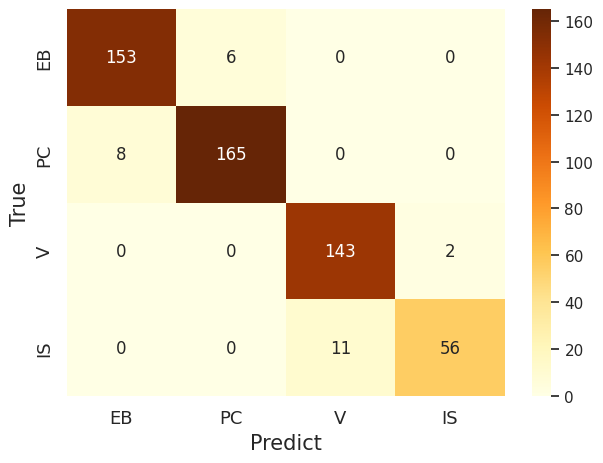

In [18]:
confusion_mat = confusion_matrix(y_test.argmax(axis=1), y_predict)
#confusion_mat = confusion_matrix(snrpc1_y.argmax(axis=1), y_predict)
#cm = pd.DataFrame(confusion_mat, columns=['EB/PC','V/IS'],index=['EB/PC','V/IS'])  # 为了修改矩阵坐标
cm = pd.DataFrame(confusion_mat, columns=['EB','PC','V','IS'],index=['EB','PC','V','IS'])  # 为了修改矩阵坐标
#cm = pd.DataFrame(confusion_mat, columns=['EB','PC',],index=['EB','PC'])  # 为了修改矩阵坐标

# 打混淆矩阵
print('混淆矩阵：')
print(confusion_mat)

# 将混淆矩阵以热力图显示
import seaborn as sns
sns.set()
figure, ax = plt.subplots() # dpi=300
# 画热力图
sns.heatmap(cm, cmap='YlOrBr', fmt='.20g', annot=True, ax=ax)    # cmap="YlGnBu_r",
# 标题 
#ax.set_title('confusion matrix')
# x轴为预测类别
ax.set_xlabel('Predict',fontsize=15,fontname='Times New Roman')  
# y轴实际类别
ax.set_ylabel('True',fontsize=15,fontname='Times New Roman') 

plt.xticks(fontsize=13,fontname='Times New Roman')
plt.yticks(fontsize=13,fontname='Times New Roman')
plt.tight_layout() 
plt.show()

figure.savefig("混淆矩阵2.png", dpi=400)

In [41]:
from sklearn.metrics import roc_curve, auc
y_true = y_test.argmax(axis=1)
y_score = model.predict(X_test)

17/17 [==============================] - 0s 5ms/step


In [44]:
y_true

array([3, 2, 1, 3, 1, 1, 1, 1, 3, 2, 1, 0, 2, 0, 2, 3, 0, 1, 2, 0, 2, 1,
       2, 2, 3, 1, 0, 1, 2, 1, 1, 2, 1, 2, 0, 0, 2, 1, 1, 2, 1, 1, 2, 2,
       3, 2, 1, 1, 0, 1, 1, 1, 1, 1, 2, 1, 1, 0, 3, 2, 0, 1, 0, 1, 0, 2,
       1, 2, 2, 0, 2, 3, 2, 0, 0, 2, 3, 2, 3, 2, 2, 1, 0, 0, 1, 1, 1, 2,
       0, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 0, 0, 1, 3, 2, 1,
       1, 0, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 3, 3, 0, 1, 0,
       1, 1, 0, 2, 0, 1, 0, 1, 0, 2, 3, 1, 0, 2, 0, 3, 2, 0, 0, 0, 3, 0,
       1, 2, 1, 0, 1, 0, 0, 0, 2, 0, 3, 1, 0, 1, 0, 3, 1, 1, 3, 0, 0, 2,
       1, 2, 1, 2, 3, 2, 2, 2, 1, 0, 0, 1, 1, 1, 3, 0, 1, 2, 1, 2, 2, 1,
       0, 0, 1, 1, 3, 0, 1, 0, 0, 2, 0, 0, 2, 1, 2, 0, 3, 2, 2, 1, 1, 1,
       2, 2, 1, 3, 1, 0, 0, 1, 0, 1, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 3, 0,
       0, 1, 0, 1, 0, 2, 1, 1, 2, 1, 2, 0, 0, 3, 0, 0, 0, 0, 0, 2, 1, 1,
       1, 2, 3, 2, 1, 2, 2, 1, 2, 3, 3, 0, 3, 2, 1, 2, 2, 2, 1, 0, 2, 0,
       0, 1, 2, 3, 0, 0, 0, 0, 2, 0, 0, 3, 2, 0, 0,

In [65]:
names=['EB','PC','V','IS']
# Initialize lists to store TPR, FPR, and AUC for each class
tpr_list = []
fpr_list = []
auc_list = []

thresholds = np.linspace(0, 1, 100)  # 使用更多的阈值
# Calculate TPR, FPR, and AUC for each class
for i in range(np.max(y_true) + 1):
    true_binary = (y_true == i).astype(int)
    predict_binary = (y_predict == i).astype(int)
    #fpr, tpr, _ = roc_curve(true_binary, predict_binary)
    fpr, tpr, _ = roc_curve(true_binary, predict_binary, thresholds=thresholds)

    roc_auc = auc(fpr, tpr)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    auc_list.append(roc_auc)
    
# 绘制每个类别的ROC曲线
fig = plt.figure(figsize=(8,6))  # 设置宽度为6，高度为8 ,dpi=300
plt.style.use('default') #('seaborn')
# 手动更改背景颜色
fig.patch.set_facecolor('white')
plt.grid(False)
# Plot ROC curves for each class
for i in range(len(tpr_list)):
    plt.plot(fpr_list[i], tpr_list[i],  label='ROC curve of class {} (AUC = {:.4f})'.format(names[i], auc_list[i]))
    

plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate',fontdict={"family": "Times New Roman", "style": "normal",'size': 20,})
plt.ylabel('True Positive Rate',fontdict={"family": "Times New Roman", "style": "normal",'size': 20,})
#plt.title('Some extension of Receiver operating characteristic to multi-class')
#plt.title('ROC Curve for 4-Class Classification')
plt.legend(loc='lower right')

plt.xticks(fontsize=16,fontname='Times New Roman')
plt.yticks(fontsize=16,fontname='Times New Roman')

ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')

# Print AUC for each class
for i in range(len(auc_list)):# 保存图形为图片文件
    print(f"Class {i} - AUC: {auc_list[i]:.4f}")
    
fig.savefig("roc2.png", dpi=400)

TypeError: roc_curve() got an unexpected keyword argument 'thresholds'

In [ ]:
#test中 pc 被错分的序号

misPC = []
for i in range(len(y_predict)):
    #predicted_label = np.argmax(predictions[i])  # 假设模型输出为概率向量，使用argmax获取预测标签
    #true_label = np.argmax(y1[i])  # 假设真实标签为独热编码形式，使用argmax获取真实标签
    if y_predict[i] != 1 and y_test1[i] == 1: # pc 被错分
        print(i,y_predict[i],y_test1[i])
        misPC.append(i)

In [ ]:
#train中 pc 被错分的序号

y_train_predict = np.argmax(model.predict(X_train), axis=1)  # 得出 0 1 2 3 
y_train1 = np.argmax(y_train, axis=1)

misPC2 = []
for i in range(len(y_train_predict)):
    #predicted_label = np.argmax(predictions[i])  # 假设模型输出为概率向量，使用argmax获取预测标签
    #true_label = np.argmax(y1[i])  # 假设真实标签为独热编码形式，使用argmax获取真实标签
    if y_train_predict[i] != 1 and y_train1[i] == 1: # pc 被错分
        print(i,y_train_predict[i],y_train1[i])
        misPC2.append(i)

In [ ]:
#test中 所有pc 的序号

pcidx = []
for i in range(len(y_predict)):
    #predicted_label = np.argmax(predictions[i])  # 假设模型输出为概率向量，使用argmax获取预测标签
    #true_label = np.argmax(y1[i])  # 假设真实标签为独热编码形式，使用argmax获取真实标签
    if  y_test1[i] == 1:  # label=pc
        print(i,y_predict[i],y_test1[i])
        pcidx.append([i,y_predict[i],y_test1[i]])
len(pcidx)

In [ ]:
# train中 所有pc 的序号

pcidx2 = []
for i in range(len(y_train_predict)):
    #predicted_label = np.argmax(predictions[i])  # 假设模型输出为概率向量，使用argmax获取预测标签
    #true_label = np.argmax(y1[i])  # 假设真实标签为独热编码形式，使用argmax获取真实标签
    if  y_train1[i] == 1:  # label=pc
        print(i,y_train_predict[i],y_train1[i])
        pcidx2.append([i,y_train_predict[i],y_train1[i]])
len(pcidx2)

In [ ]:
# test中 pc 的属性 snr

snr_values = []
for i in range(len(pcidx)):
    snr_values.append(test.iloc[pcidx[i][0],4])
    print(i, test.loc[pcidx[i][0], ['TIC','estimate_snr_aver','period','type']].values)

In [ ]:
len(snr_values)

In [ ]:
# train中 pc 的属性 snr

snr_values2 = []
for i in range(len(pcidx2)):
    snr_values2.append(train.iloc[pcidx2[i][0],4])
    print(i, train.loc[pcidx2[i][0], ['TIC','estimate_snr_aver','period','type']].values)

In [ ]:
len(snr_values2)

In [ ]:
# pcidx: index in test, y_predict[i], y_test1[i]

new_y_predict_pclist = []
new_y_true_pclist = []

for i in pcidx:
    if i[1] != 1: #predict not pc
        new_y_predict_pclist.append(0)
    else:
        new_y_predict_pclist.append(1)
    if i[2] != 1: #true not pc
        new_y_true_pclist.append(0)
    else:
        new_y_true_pclist.append(1)
len(new_y_predict_pclist),len(new_y_true_pclist)

In [ ]:
#train
# pcidx: index in test, y_predict[i], y_test1[i]

new_y_train_predict_pclist = []
new_y_train_true_pclist = []

for i in pcidx2:
    if i[1] != 1: #predict not pc
        new_y_train_predict_pclist.append(0)
    else:
        new_y_train_predict_pclist.append(1)
    if i[2] != 1: #true not pc
        new_y_train_true_pclist.append(0)
    else:
        new_y_train_true_pclist.append(1)
len(new_y_train_predict_pclist),len(new_y_train_true_pclist)

In [ ]:
true_labels

In [ ]:
'画图，横坐标是snr分组，纵坐标是tp 真正率 = 该组predict为pc/ 该组总数'
'现在组里全是pc'
'True Positive Rate（真正率 , TPR）或灵敏度（sensitivity） ,TPR = TP /（TP + FN） = 正样本预测结果数 / 正样本实际数'


# 找到列表中的最大值和最小值
min_value = min(snr_values)
max_value = max(snr_values)

# train_
min_train_value = min(snr_values2)
max_train_value = max(snr_values2)


# 计算范围的长度
range_length = max_value - min_value
# 计算可以分成多少组，每组之间的间隔为0.1  # 划分数据集为不同SNR分组，每组0.1间隔
num_groups = int(range_length / 0.1)  #10个分组，0.1间隔

# train_
range_train_length = max_train_value - min_train_value
num_train_groups = int(range_train_length / 0.1)  #10个分组，0.1间隔


group_size = 0.1
snr_groups = np.arange(min_value, max_value, group_size)

# train_
snr_train_groups = np.arange(min_train_value, max_train_value, group_size)


true_labels = np.array(new_y_predict_pclist)   # test中对pc类的预测
# 初始化列表以存储每个组的真正例率（TPR）
tpr_per_group = []

# train_
true_train_labels = np.array(new_y_train_predict_pclist)   # train_中对pc类的预测
# 初始化列表以存储每个组的真正例率（TPR）
tpr_per_train_group = []


# train_
train_mid = []
for i in range(num_train_groups):
    group_start = snr_train_groups[i]
    group_end = snr_train_groups[i + 1]
    mids = (group_start+group_end)/2
    train_mid.append(mids)

    # 选择处于当前SNR组范围内的样本
    group_indices = np.where((snr_values2 >= group_start) & (snr_values2 < group_end))[0]
    # 计算当前组的真正例率 (TPR)
    #print(true_train_labels[group_indices])
    TP = np.sum(true_train_labels[group_indices])
    TP_FN = len(group_indices)
    TPR = TP /(TP_FN) if TP_FN !=0 else 0
    tpr_per_train_group.append(TPR)

# 使用列表推导式筛选出非零的值
filtered_snr_train_groups = [snr for snr, tpr in zip(train_mid, tpr_per_train_group) if tpr != 0]
filtered_tpr_per_train_group = [tpr for tpr in tpr_per_train_group if tpr != 0]


# 计算每个组的真正例率
mid = []
for i in range(num_groups):
    group_start = snr_groups[i]
    group_end = snr_groups[i + 1]
    mids = (group_start+group_end)/2
    mid.append(mids)

    # 选择处于当前SNR组范围内的样本
    group_indices = np.where((snr_values >= group_start) & (snr_values < group_end))[0]
    # 计算当前组的真正例率 (TPR)
    #print(true_labels[group_indices])
    TP = np.sum(true_labels[group_indices])
    TP_FN = len(group_indices)
    TPR = TP /(TP_FN) if TP_FN !=0 else 0
    tpr_per_group.append(TPR)

# 使用列表推导式筛选出非零的值
filtered_snr_groups = [snr for snr, tpr in zip(mid, tpr_per_group) if tpr != 0]
filtered_tpr_per_group = [tpr for tpr in tpr_per_group if tpr != 0]


#cmap = get_cmap("") #"viridis"
# 绘制图表

fig = plt.figure(figsize=(8,6))  # 设置宽度为6，高度为8 ,dpi=300

plt.style.use('default') #('seaborn')
# 手动更改背景颜色
fig.patch.set_facecolor('white')
plt.grid(False)

plt.scatter(filtered_snr_train_groups , filtered_tpr_per_train_group, color="cornflowerblue",label="Train",s=15)
plt.plot(filtered_snr_groups , filtered_tpr_per_group, color="darkorange",label="Test",)
plt.xlabel('SNR',fontsize=16,)
plt.ylabel('True Positive Rate',fontsize=16)

plt.xticks(fontsize=16,fontname='Times New Roman')
plt.yticks(fontsize=16,fontname='Times New Roman')
#plt.title('TPR vs. SNR')
# 添加图例
plt.legend()
#plt.grid(True)
plt.show()
fig.savefig("TPRSNR", dpi=400)

In [ ]:
X_train.shape, X_train[0].shape, X_train[0][:,0].shape

In [ ]:
[:, 0]

In [ ]:
def neyman_pearson_optimal_detector(data, threshold_sigma):
    """
    创建 Neyman-Pearson 最优检测器并设置阈值

    参数:
    - data: 包含观测数据的数组
    - threshold_sigma: 设定的阈值，以标准差为单位

    返回:
    - result: 返回 True 表示拒绝零假设，False 表示不拒绝零假设
    拒绝零假设"，那么这意味着我们检测到了均值的显著变化
    """

    # 计算观测数据的均值和标准差
    data_mean = np.mean(data)
    data_std = np.std(data)

    # 计算检测统计量
    detection_statistic = (data_mean - threshold_sigma * data_std)

    # 设置 7.1-sigma 阈值
    threshold = data_mean - 7.1 * data_std

    # 判断是否拒绝零假设
    result = detection_statistic > threshold

    return result


In [ ]:
# 设定 7.1-sigma 阈值
threshold_sigma = 7.1

res = []

# 使用 Neyman-Pearson 最优检测器进行假设检验
for i in range(len(y_train1)):
    if y_train1[i] == 1:   # label ==pc
        a = neyman_pearson_optimal_detector(X_train[i][:,0], threshold_sigma)
        b = neyman_pearson_optimal_detector(X_train[i][:,1], threshold_sigma)

        # 输出检测结果
        if b:
            res.append(1)  # 拒绝零假设
        else:
            res.append(0)  # print("不拒绝零假设")

In [ ]:
len(res),len(X_train),len(y_train1)

In [ ]:
Counter(res)

In [19]:
test = pd.read_csv('/kaggle/input/finllay-fig/X_test_t1.csv',low_memory=False)
#test = test[~test.duplicated('TIC')]    # 去重
train = pd.read_csv('/kaggle/input/finllay-fig/X_train_t1.csv',low_memory=False)

In [20]:
len(al)

1716

In [33]:
al =  pd.concat([train, test], axis=0)
al['type'].value_counts()

type
PC    1716
EB    1634
V     1462
IS     596
Name: count, dtype: int64

In [34]:
al = al[al['type']=='V']

In [35]:
al['titchN']

0      1.0
6      1.0
10     1.0
11     1.0
15     1.0
      ... 
732    1.0
733    1.0
738    1.0
740    1.0
744    1.0
Name: titchN, Length: 1462, dtype: float64

In [36]:
al['titchN'].value_counts(), len(al)

(titchN
 1.0    1462
 Name: count, dtype: int64,
 1462)

In [8]:
v1 = train[train['type']=='V']
v2 = test[test['type']=='V']
v =  pd.concat([v1, v2], axis=0)
v

,TIC,toiCount,planet_cnt,xml_sectors_range,estimate_snr_aver,period,type,label,0,1,...,Tmag,sectors,titchN,Disposition,Period,Duration,Transit_Depth,star_rad,SN,subtype
0,350336617,NaN,NaN,NaN,NaN,NaN,V,2.0,0.127210,0.141139,...,NaN,6,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
6,111868456,NaN,NaN,NaN,NaN,NaN,V,2.0,0.907059,0.903726,...,NaN,11,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
10,35420590,NaN,NaN,NaN,NaN,NaN,V,2.0,0.115235,0.068384,...,NaN,7,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
11,59661876,NaN,NaN,NaN,NaN,NaN,V,2.0,0.237300,0.177497,...,NaN,13,1.0,NaN,NaN,NaN,NaN,NaN,NaN,ACF
15,314051148,NaN,NaN,NaN,NaN,NaN,V,2.0,0.245487,0.161185,...,NaN,14,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732,141330327,NaN,NaN,NaN,NaN,NaN,V,2.0,0.107114,0.108688,...,NaN,23,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal
733,268507466,NaN,NaN,NaN,NaN,NaN,V,2.0,0.478754,0.502577,...,NaN,19,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Double-sinusoidal
738,63072266,NaN,NaN,NaN,NaN,NaN,V,2.0,0.739750,0.729341,...,NaN,15,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Double-sinusoidal
740,68059359,NaN,NaN,NaN,NaN,NaN,V,2.0,0.677032,0.648605,...,NaN,23,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Single-sinusoidal


In [9]:
v['type'].value_counts(), v['subtype'].value_counts()

(type
 V    1462
 Name: count, dtype: int64,
 subtype
  Single-sinusoidal    556
 Double-sinusoidal     494
 ACF                   412
 Name: count, dtype: int64)

In [37]:
counts = v['subtype'].value_counts()
counts

subtype
 Single-sinusoidal    556
Double-sinusoidal     494
ACF                   412
Name: count, dtype: int64

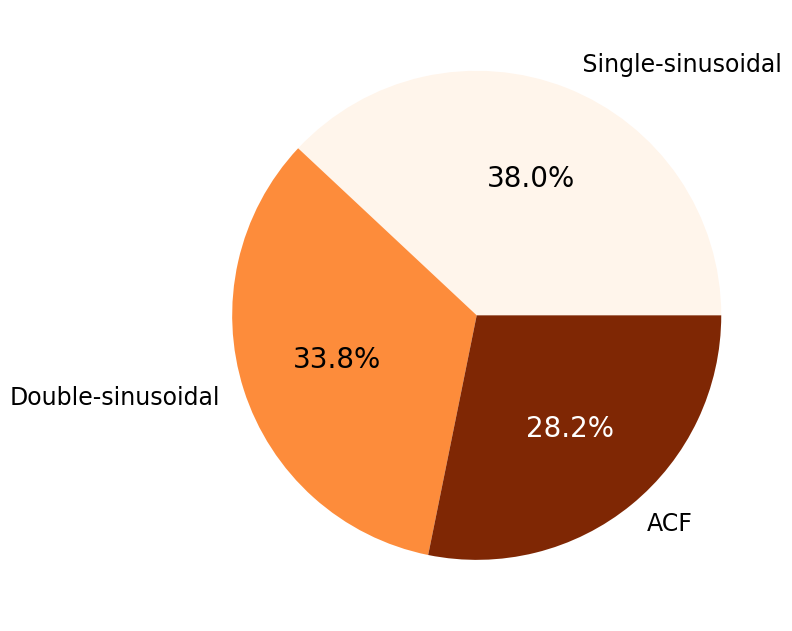

In [51]:
# 使用 magma 调色板生成颜色
import matplotlib.cm as cm
colors = cm.Oranges(np.linspace(0, 1, 3))
# 绘制饼图
fig, ax = plt.subplots(figsize=(8,8))
wedges, texts, autotexts = ax.pie(counts, labels=counts.index,  colors =colors,  autopct='%1.1f%%')
autotexts[2].set_color('white')
for autotext in autotexts:
    autotext.set_fontsize(20)
for autotext in texts:
    autotext.set_fontsize(17)
plt.tight_layout() 
# 显示图形
plt.show()
fig.savefig("vbin.png", dpi=400)

In [18]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import manifold, datasets

In [11]:
name = ['EB','PC','V','IS']

In [60]:
model.predict(X_test)

17/17 [==============================] - 0s 6ms/step


array([[2.1880724e-05, 6.3288136e-04, 4.4536325e-03, 9.9489152e-01],
       [1.1005061e-03, 1.1505004e-04, 9.7262156e-01, 2.6162878e-02],
       [1.0402995e-01, 8.9596587e-01, 1.0856616e-07, 4.0058317e-06],
       ...,
       [1.6542879e-07, 3.8448256e-06, 9.9721539e-01, 2.7805991e-03],
       [4.0023646e-01, 5.9976208e-01, 7.8395658e-08, 1.3738249e-06],
       [9.9569845e-01, 4.2989729e-03, 1.2852267e-06, 1.3480420e-06]],
      dtype=float32)

In [56]:
labels.shape, y_predict.shape

((544,), (544,))

17/17 [==============================] - 0s 5ms/step


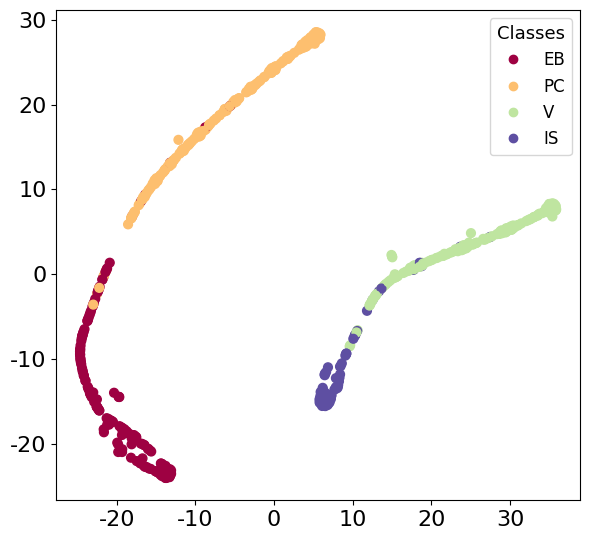

In [46]:
data = model.predict(X_test)   # 假设有100个样本，每个样本有10个特征
#data = X_test
labels = y 

# 创建T-SNE对象并拟合数据
tsne = manifold.TSNE(n_components=2, random_state=0)
embedding = tsne.fit_transform(data)

# 绘制可视化图形
fig = plt.figure(figsize=[6,5.5] ) # ,dpi=300
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=labels, cmap='Spectral', s=40)
#plt.title("T-SNE Visualization")
legend = plt.legend(handles = scatter.legend_elements()[0], labels=name, title="Classes", fontsize='large')
#plt.colorbar()
plt.xticks(fontsize=16,fontname='Times New Roman')
plt.yticks(fontsize=16,fontname='Times New Roman')
legend.get_title().set_fontsize('13')  # 设置字号
#plt.tight_layout() 
plt.tight_layout() 
# 显示图形
plt.show()
fig.savefig("tsneval2.png", dpi=400)

In [78]:
np.max(y_true) + 1

4

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, accuracy_score
import numpy as np

# 生成示例数据
y_true = np.array([0, 1, 1, 0, 1, 1, 0, 0, 1, 0])
y_scores = np.array([0.2, 0.8, 0.6, 0.3, 0.7, 0.9, 0.4, 0.1, 0.85, 0.25])

# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# 计算准确率
y_pred = (y_scores >= 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# 添加准确率信息
plt.text(0.7, 0.1, f'Accuracy = {accuracy:.2f}', fontsize=12, ha='right')

plt.show()


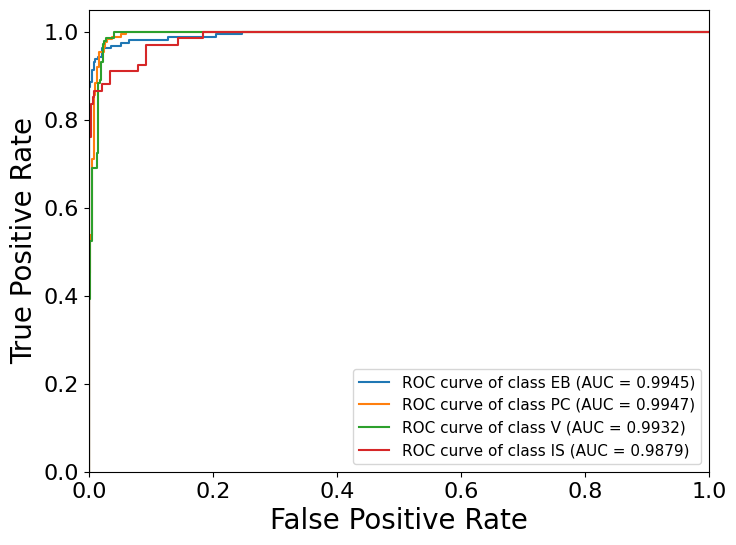

In [80]:
# 获取每个类别的预测概率 y_score
names = ['EB','PC','V','IS']
# 计算每个类别的FPR和TPR，并计算AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    # 将当前类别作为正类，其他类别作为负类
    y_true = np.where(y == i, 1, 0)
    y_pred = y_score[:, i]
    
    # 计算当前类别的FPR和TPR，并计算AUC
    fpr[i], tpr[i], _ = roc_curve(y_true, y_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制每个类别的ROC曲线
fig = plt.figure(figsize=(8,6))  # 设置宽度为6，高度为8 ,dpi=300
plt.style.use('default') #('seaborn')
# 手动更改背景颜色
fig.patch.set_facecolor('white')
plt.grid(False)

for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.4f})'.format(names[i], roc_auc[i]))


plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate',fontdict={"family": "Times New Roman", "style": "normal",'size': 20,})
plt.ylabel('True Positive Rate',fontdict={"family": "Times New Roman", "style": "normal",'size': 20,})
#plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right",fontsize=11)

plt.xticks(fontsize=16,fontname='Times New Roman')
plt.yticks(fontsize=16,fontname='Times New Roman')

ax = plt.gca()
ax.spines['left'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')

plt.show()


In [82]:
len(fpr[i])

22

In [30]:
len(y_pred), len(y_true)

(544, 544)

In [35]:
y_pred.ravel()

array([0, 0, 0, ..., 0, 0, 0])

In [37]:
len(y_pred)

544

In [ ]:
from sklearn.metrics import auc, roc_curve, accuracy_score


tpr_list = []
fpr_list = []
auc_list = []

# Calculate TPR, FPR, and AUC for each class
for i in range(np.max(y_true) + 1):
    true_binary = (y_true == i).astype(int)
    predict_binary = (y_predict == i).astype(int)
    fpr, tpr, _ = roc_curve(true_binary, predict_binary)
    roc_auc = auc(fpr, tpr)
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    auc_list.append(roc_auc)
    

# 计算 ROC 曲线
#fpr, tpr, _ = roc_curve(y_true, y_scores)
#roc_auc = auc(fpr, tpr)

# 计算准确率
y_pred = (y_scores >= 0.5).astype(int)
accuracy = accuracy_score(y_true, y_predict)

# 绘制 ROC 曲线和准确率曲线
plt.figure(figsize=(10, 6))

# 绘制 ROC 曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# 绘制准确率曲线
thresholds = np.linspace(0, 1, 10)
accuracy_curve = [accuracy_score(y_true, (y_scores >= threshold).astype(int)) for threshold in thresholds]
plt.plot(thresholds, accuracy_curve, color='green', lw=2, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
print("y_true shape:", y_true.shape)
print("y_pred shape:", y_pred.shape)

y_true shape: (544,)
y_pred shape: (544, 4)


In [53]:
y_true = y_test.argmax(axis=1)
y_score = model.predict(X_test)

17/17 [==============================] - 0s 5ms/step


In [56]:
len(y_score), len(y_true)

(544, 544)

In [44]:
accuracy_score(np.argmax(y_test, axis=1), predicted_labels).astype(int)

0

In [71]:
len(thresholds)

array([1.9997239e+00, 9.9972385e-01, 8.0357820e-01, 6.9245470e-01,
       5.1178491e-01, 4.8547330e-01, 4.4945320e-01, 4.3186662e-01,
       3.0498263e-01, 1.7295380e-01, 1.7228796e-01, 1.3381755e-01,
       1.0654363e-01, 4.0705498e-02, 4.0300556e-02, 3.4482181e-02,
       3.3044580e-02, 1.4413388e-02, 1.4395716e-02, 7.8958226e-03,
       7.8793662e-03, 2.0047992e-10], dtype=float32)

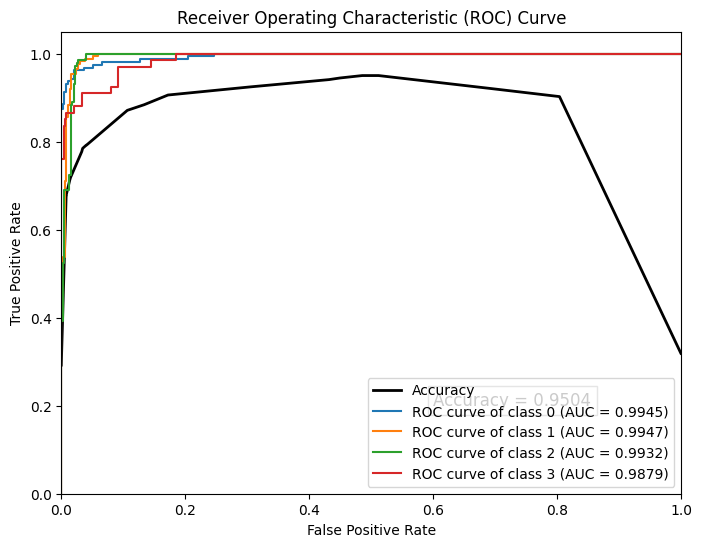

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier

# 假设 y_true 是一个包含多个整数标签的一维数组
# 假设 y_pred 是一个包含每个样本属于四个类别的概率分数的数组

y_pred = y_score

# 将 y_true 转换为二进制矩阵，每列对应一个类别
y_true_bin = label_binarize(y_true, classes=[0, 1, 2, 3])



# 计算每个类别的FPR和TPR，并计算AUC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(4):
    fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 计算准确率
predicted_labels = np.argmax(y_score, axis=1)
#accuracy = accuracy_score(np.argmax(y_test, axis=1), predicted_labels)

accuracy_curve = [accuracy_score(y_true, (y_score >= threshold).argmax(axis=1)) for threshold in thresholds]
# 绘制ROC曲线
plt.figure(figsize=(8, 6))

plt.plot(thresholds, accuracy_curve, color='black', lw=2, label='Accuracy')
plt.legend()

for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {} (AUC = {:.4f})'.format(i, roc_auc[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


# 显示准确率
plt.text(0.6, 0.2, f'Accuracy = {accuracy:.4f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.show()


In [47]:
y_true

array([2, 3, 0, 2, 2, 3, 0, 0, 2, 1, 2, 2, 2, 2, 3, 0, 3, 3, 3, 2, 1, 0,
       1, 3, 3, 1, 1, 1, 3, 3, 0, 0, 3, 1, 1, 0, 3, 0, 0, 2, 2, 2, 1, 3,
       3, 3, 3, 2, 1, 1, 2, 1, 2, 3, 2, 3, 3, 0, 2, 0, 2, 2, 0, 0, 2, 1,
       3, 0, 3, 1, 1, 1, 0, 1, 0, 1, 3, 3, 2, 3, 2, 3, 0, 3, 2, 2, 1, 0,
       3, 1, 3, 3, 1, 1, 1, 1, 1, 3, 1, 0])

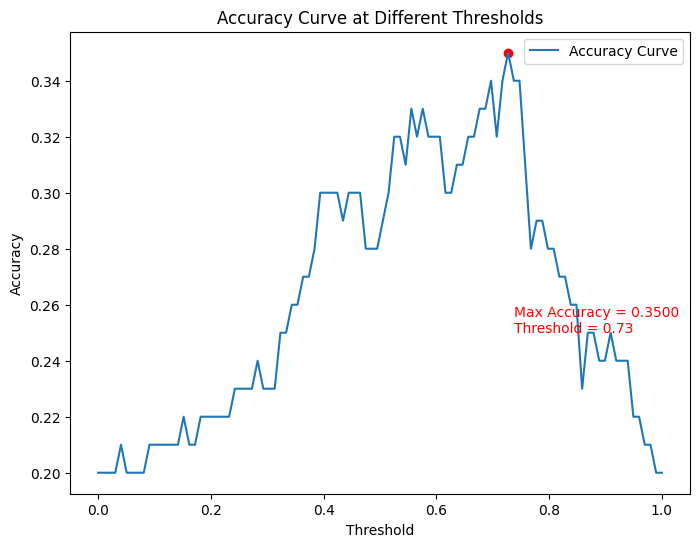

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 假设 y_true 是一个包含多个整数标签的一维数组
# 假设 y_scores 是一个包含每个样本属于四个类别的概率分数的数组

# 生成示例数据
np.random.seed(42)
y_true = np.random.randint(0, 4, size=100)
y_scores = np.random.rand(100, 4)

# 定义阈值范围
thresholds = np.linspace(0, 1, 100)

# 计算不同阈值下的准确率
accuracy_curve = [accuracy_score(y_true, (y_scores >= threshold).argmax(axis=1)) for threshold in thresholds]

# 绘制准确率曲线
plt.figure(figsize=(8, 6))
plt.plot(thresholds, accuracy_curve, label='Accuracy Curve')

# 标注最大准确率及对应的阈值
max_accuracy = max(accuracy_curve)
best_threshold = thresholds[accuracy_curve.index(max_accuracy)]
plt.scatter(best_threshold, max_accuracy, color='red')
plt.text(best_threshold + 0.01, max_accuracy - 0.1, f'Max Accuracy = {max_accuracy:.4f}\nThreshold = {best_threshold:.2f}', color='red')

plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve at Different Thresholds')
plt.legend()
plt.show()


In [67]:
# 数据准备

y = np.array([1, 1, 2, 2])
scores = np.array([0.1, 0.4, 0.35, 0.8])

# roc_curve的输入为
# y: 样本标签
# scores: 模型对样本属于正例的概率输出
# pos_label: 标记为正例的标签，本例中标记为2的即为正例
fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=2)
# 假阳性率


# auc的输入为很简单，就是fpr, tpr值
auc = metrics.auc(fpr, tpr)
auc


0.75

In [68]:
thresholds

array([1.8 , 0.8 , 0.4 , 0.35, 0.1 ])